In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV

from sklearn.feature_selection import SequentialFeatureSelector

import warnings
warnings.filterwarnings(action='ignore')

In [21]:
df = pd.read_csv('/content/drive/MyDrive/학교/Dissertation/Dissertation_final/Data Preprocessing/all_features_scaled.csv')
df

,title,page_id,char_count,word_count,sentence_count,syllable_count,complex_word_count,section_count,subsection_count,paragraph_count,...,num_edits,num_editors,num_registered_editors,num_anonymous_editors,num_occasional_editors,edit_per_day,edit_per_editor,revert_count,discussion_count,quality
0,Mayan languages,182013,0.554382,0.490641,0.350556,0.563203,0.727204,0.313583,1.614782,0.765594,...,0.202138,0.020507,0.065268,-0.021923,0.032017,0.236123,1.059491,0.210672,0.171081,1
1,Mu'awiya I,207068,1.902108,1.915008,1.614977,1.920173,1.860678,0.660305,0.804225,0.622956,...,0.706190,0.543133,0.438547,0.622440,0.507665,0.775288,0.832776,0.779877,0.635288,1
2,The Fountainhead,180464,0.527779,0.520419,0.849882,0.568074,0.666285,0.140222,1.209503,0.123721,...,0.125496,0.281341,0.104355,0.436776,0.319459,0.155290,-0.143283,-0.137176,-0.065684,1
3,Northern pintail,218361,-0.519528,-0.520312,-0.575612,-0.539584,-0.622258,-0.379860,-0.715570,-0.518153,...,-0.428819,-0.416772,-0.294330,-0.517026,-0.407130,-0.422839,-0.232880,-0.401317,-0.218555,1
4,Manhattan Project,19603,3.393837,3.347316,3.580064,3.595369,4.328846,2.567274,2.222700,2.358391,...,1.586678,1.760994,1.658053,1.798311,1.830809,1.527498,0.269954,1.507195,0.520634,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5195,Party of Democratic Kampuchea,265468,-1.022361,-1.048866,-1.042723,-1.020531,-0.919472,-1.420025,-0.918209,-0.993615,...,-0.669082,-0.726511,-0.765325,-0.666285,-0.735635,-0.677037,-0.678444,-0.555709,-0.257705,0
5196,Minawara and Multultu,95240,-1.089358,-1.108422,-1.074937,-1.095216,-1.028389,-1.593386,-0.918209,-1.136253,...,-0.688688,-0.749526,-0.792686,-0.684488,-0.755026,-0.698471,-1.323641,-0.559429,-0.266094,0
5197,Theophylline/ephedra/hydroxyzine,262652,-1.095542,-1.115618,-1.082991,-1.101530,-1.032081,-1.593386,-0.918209,-1.136253,...,-0.684766,-0.744731,-0.786822,-0.680847,-0.751604,-0.693822,-1.131271,-0.557569,-0.266094,0
5198,"Channel Lake, Illinois",111450,-1.004166,-1.005192,-0.986347,-1.010428,-0.971161,-1.246665,-0.715570,-0.993615,...,-0.675142,-0.732265,-0.759462,-0.682668,-0.740197,-0.684439,-0.865996,-0.561290,-0.263298,0


In [22]:
def train_and_evaluate_models(X, y, cv=5, test_size=0.2):
    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42, stratify=y)

    # Initialize the models
    models = {
        'Logistic Regression': LogisticRegression(),
        'SVM': SVC(),
        'Random Forest': RandomForestClassifier(),
        'AdaBoost': AdaBoostClassifier(),
        'XGBoost': XGBClassifier(),
        'MLP': MLPClassifier(),
        'KNN': KNeighborsClassifier()
    }

    # Initialize a list to store the results
    results = []

    # Define custom scoring
    scoring = {
        'accuracy': make_scorer(accuracy_score),
        'precision': make_scorer(precision_score, average='weighted'),
        'recall': make_scorer(recall_score, average='weighted'),
        'f1': make_scorer(f1_score, average='weighted')
    }

    # StratifiedKFold for cross-validation
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)

    # Loop through the models
    for model_name, model in models.items():
        # Perform cross-validation on the training set
        cv_results = {metric: cross_val_score(model, X_train, y_train, cv=skf, scoring=scorer).mean() for metric, scorer in scoring.items()}

        # Train the model on the full training set
        model.fit(X_train, y_train)

        # Predict the test set
        y_pred = model.predict(X_test)

        # Calculate the metrics on the test set
        test_accuracy = accuracy_score(y_test, y_pred)
        test_precision = precision_score(y_test, y_pred, average='weighted')
        test_recall = recall_score(y_test, y_pred, average='weighted')
        test_f1 = f1_score(y_test, y_pred, average='weighted')

        # Append the results to the list
        results.append({
            'Model': model_name,
            'CV Accuracy': cv_results['accuracy'],
            'CV Precision': cv_results['precision'],
            'CV Recall': cv_results['recall'],
            'CV F1 Score': cv_results['f1'],
            'Test Accuracy': test_accuracy,
            'Test Precision': test_precision,
            'Test Recall': test_recall,
            'Test F1 Score': test_f1
        })

    # Create a dataframe from the results
    results_df = pd.DataFrame(results)

    return results_df

__Skewed data__
- 'char_count', 'word_count' ,''sentence_count', 'syllable_count', 'complex_word_count'
- 'section_count'?, 'subsection_count' , 'paragraph_count', 'mean_section_size', 'longest_section_size', 'shortest_section_size', 'abstract_size'?, 'abstract_text_ratio', 'citation_count', 'citation_per_text', 'external_link_count', 'internal_link_count', 'link_per_text', 'image_count', 'image_per_text'
- 'largest_sentence_size'?, 'shortest_sentence_size', 'question_count', 'exclamation_count', 'pronoun_start_count', 'pronoun_start_count_sentence_ratio'
- 'num_edits', 'num_editors', 'num_registered_editors', 'num_anonymous_editors', 'num_occasional_editors', 'edit_per_day', 'edit_per_editor'?, 'revert_count', 'discussion_count'

__Not skewed data__
- 'mean_paragraph_size', 'infobox'
- 'mean_sentence_size'
- 'ARI', 'CLI', 'FRE', 'FKG', 'GFI', 'LIX', 'SMOG'
- 'article_age_days'

In [23]:
scaling_features = df.columns
exclude_features = ['title', 'page_id', 'infobox', 'quality']
scaling_features = scaling_features.difference(exclude_features)

# Standardisation
#scaler = StandardScaler()
scaler = MinMaxScaler()

df_scaled = df.copy()
df_scaled[scaling_features] = scaler.fit_transform(df_scaled[scaling_features])
df_scaled

,title,page_id,char_count,word_count,sentence_count,syllable_count,complex_word_count,section_count,subsection_count,paragraph_count,...,num_edits,num_editors,num_registered_editors,num_anonymous_editors,num_occasional_editors,edit_per_day,edit_per_editor,revert_count,discussion_count,quality
0,Mayan languages,182013,0.169354,0.172497,0.169014,0.165418,0.158208,0.179104,0.3125,0.091533,...,0.090476,0.097928,0.093522,0.069728,0.105186,0.092429,0.157678,0.070674,0.014284,1
1,Mu'awiya I,207068,0.306893,0.324498,0.316432,0.299572,0.259712,0.208955,0.2125,0.084668,...,0.141103,0.162463,0.132186,0.137169,0.166618,0.145170,0.143943,0.122786,0.029418,1
2,The Fountainhead,180464,0.166639,0.175675,0.227230,0.165900,0.152753,0.164179,0.2625,0.060641,...,0.082778,0.130136,0.097571,0.117737,0.142310,0.084522,0.084809,0.038828,0.006564,1
3,Northern pintail,218361,0.059760,0.064614,0.061033,0.056394,0.037362,0.119403,0.0250,0.029748,...,0.027103,0.043931,0.056275,0.017908,0.048468,0.027969,0.079380,0.014646,0.001580,1
4,Manhattan Project,19603,0.459127,0.477346,0.545540,0.465186,0.480741,0.373134,0.3875,0.168192,...,0.229538,0.312848,0.258502,0.260240,0.337507,0.218752,0.109844,0.189373,0.025680,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5195,Party of Democratic Kampuchea,265468,0.008444,0.008209,0.006573,0.008846,0.010746,0.029851,0.0000,0.006865,...,0.002972,0.005684,0.007490,0.002286,0.006040,0.003103,0.052386,0.000511,0.000304,0
5196,Minawara and Multultu,95240,0.001607,0.001854,0.002817,0.001462,0.000992,0.014925,0.0000,0.000000,...,0.001003,0.002842,0.004656,0.000381,0.003536,0.001007,0.013297,0.000170,0.000030,0
5197,Theophylline/ephedra/hydroxyzine,262652,0.000976,0.001086,0.001878,0.000838,0.000661,0.014925,0.0000,0.000000,...,0.001396,0.003434,0.005263,0.000762,0.003978,0.001461,0.024952,0.000341,0.000030,0
5198,"Channel Lake, Illinois",111450,0.010301,0.012870,0.013146,0.009845,0.006117,0.044776,0.0250,0.006865,...,0.002363,0.004973,0.008097,0.000572,0.005451,0.002379,0.041024,0.000000,0.000122,0


In [45]:
columns_to_exclude = ['title', 'page_id', 'mean_paragraph_size', 'infobox', 'mean_sentence_size',
                      'ARI', 'CLI', 'FRE', 'FKG', 'GFI', 'LIX', 'SMOG', 'article_age_days',
                      'quality']
columns_to_transform = df_scaled.columns.difference(columns_to_exclude)

df_transformed = df_scaled.copy()
#df_transformed = df.copy()
#df_transformed[columns_to_transform] = df_transformed[columns_to_transform].apply(lambda x: np.log(x))
df_transformed[columns_to_transform] = df_transformed[columns_to_transform].apply(lambda x: np.sqrt(x))
df_transformed

,title,page_id,char_count,word_count,sentence_count,syllable_count,complex_word_count,section_count,subsection_count,paragraph_count,...,num_edits,num_editors,num_registered_editors,num_anonymous_editors,num_occasional_editors,edit_per_day,edit_per_editor,revert_count,discussion_count,quality
0,Mayan languages,182013,0.411527,0.415327,0.411113,0.406716,0.397754,0.423207,0.559017,0.302545,...,0.300793,0.312934,0.305814,0.264060,0.324323,0.304021,0.397087,0.265847,0.119514,1
1,Mu'awiya I,207068,0.553979,0.569647,0.562523,0.547332,0.509620,0.457116,0.460977,0.290978,...,0.375636,0.403067,0.363574,0.370363,0.408188,0.381012,0.379398,0.350408,0.171517,1
2,The Fountainhead,180464,0.408215,0.419136,0.476687,0.407308,0.390836,0.405190,0.512348,0.246253,...,0.287712,0.360744,0.312363,0.343128,0.377240,0.290727,0.291219,0.197049,0.081021,1
3,Northern pintail,218361,0.244458,0.254192,0.247048,0.237474,0.193291,0.345547,0.158114,0.172477,...,0.164631,0.209598,0.237224,0.133821,0.220154,0.167240,0.281745,0.121020,0.039753,1
4,Manhattan Project,19603,0.677589,0.690902,0.738607,0.682046,0.693355,0.610847,0.622495,0.410112,...,0.479101,0.559328,0.508431,0.510137,0.580954,0.467709,0.331428,0.435170,0.160250,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5195,Party of Democratic Kampuchea,265468,0.091893,0.090604,0.081073,0.094054,0.103661,0.172774,0.000000,0.082855,...,0.054513,0.075391,0.086544,0.047814,0.077718,0.055707,0.228880,0.022603,0.017433,0
5196,Minawara and Multultu,95240,0.040089,0.043054,0.053074,0.038242,0.031494,0.122169,0.000000,0.000000,...,0.031662,0.053310,0.068234,0.019520,0.059461,0.031726,0.115314,0.013050,0.005513,0
5197,Theophylline/ephedra/hydroxyzine,262652,0.031242,0.032950,0.043335,0.028952,0.025715,0.122169,0.000000,0.000000,...,0.037368,0.058600,0.072548,0.027605,0.063068,0.038227,0.157962,0.018455,0.005513,0
5198,"Channel Lake, Illinois",111450,0.101495,0.113445,0.114654,0.099221,0.078209,0.211604,0.158114,0.082855,...,0.048611,0.070522,0.089984,0.023907,0.073830,0.048776,0.202543,0.000000,0.011026,0


In [46]:
df_transformed.isnull().sum()

title                                 0
page_id                               0
char_count                            0
word_count                            0
sentence_count                        0
syllable_count                        0
complex_word_count                    0
section_count                         0
subsection_count                      0
paragraph_count                       0
mean_section_size                     0
mean_paragraph_size                   0
longest_section_size                  0
shortest_section_size                 0
abstract_size                         0
abstract_text_ratio                   0
citation_count                        0
citation_per_text                     0
external_link_count                   0
internal_link_count                   0
link_per_text                         0
image_count                           0
image_per_text                        0
infobox                               0
mean_sentence_size                    0


__length features__

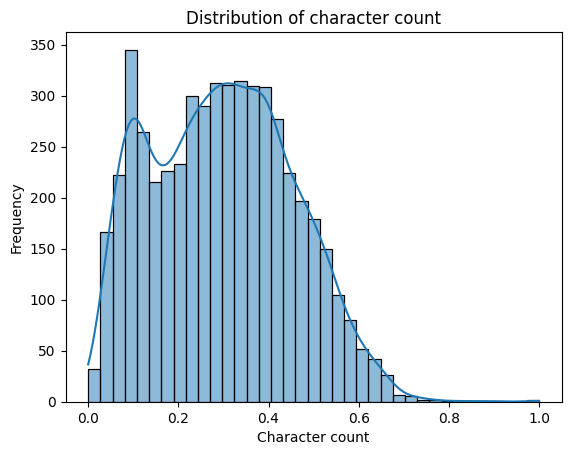

In [47]:
# Character count
sns.histplot(df_transformed['char_count'], kde=True)

plt.title('Distribution of character count')
plt.xlabel('Character count')
plt.ylabel('Frequency')
plt.show()

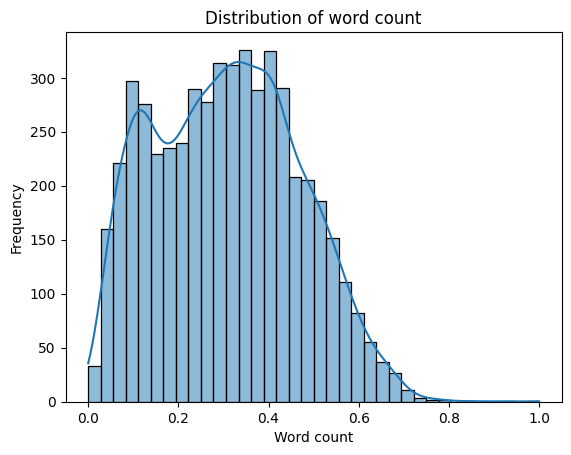

In [48]:
# Word count
sns.histplot(df_transformed['word_count'], kde=True)

plt.title('Distribution of word count')
plt.xlabel('Word count')
plt.ylabel('Frequency')
plt.show()

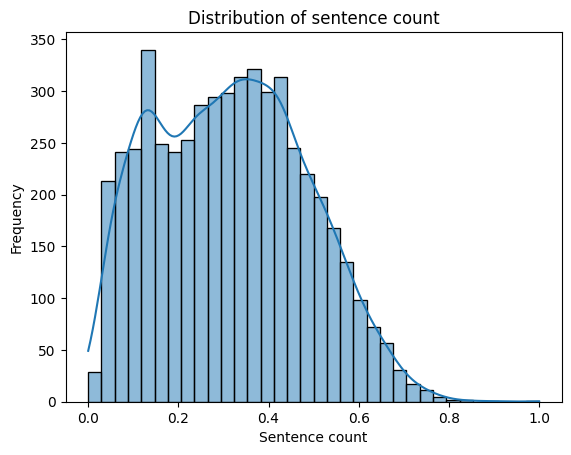

In [51]:
# Sentence count
sns.histplot(df_transformed['sentence_count'], kde=True)

plt.title('Distribution of sentence count')
plt.xlabel('Sentence count')
plt.ylabel('Frequency')
plt.show()

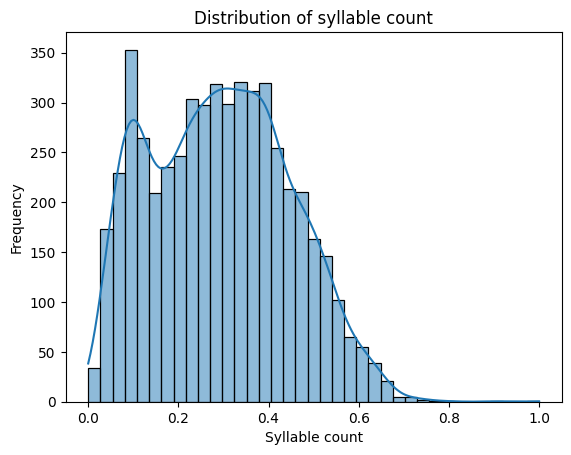

In [52]:
# Syllable count
sns.histplot(df_transformed['syllable_count'], kde=True)

plt.title('Distribution of syllable count')
plt.xlabel('Syllable count')
plt.ylabel('Frequency')
plt.show()

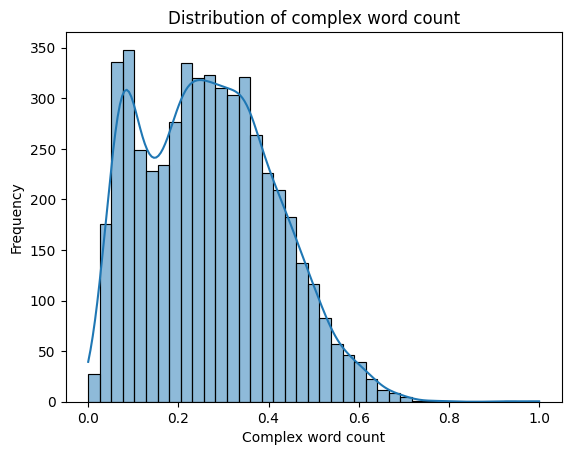

In [53]:
# Complex word count
sns.histplot(df_transformed['complex_word_count'], kde=True)

plt.title('Distribution of complex word count')
plt.xlabel('Complex word count')
plt.ylabel('Frequency')
plt.show()

__structure features__

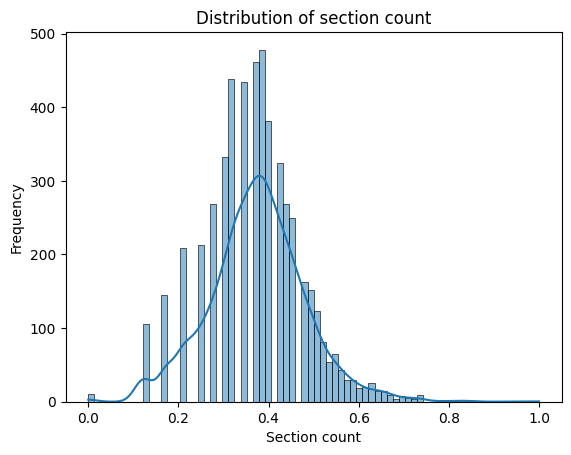

In [55]:
# Section count
sns.histplot(df_transformed['section_count'], kde=True)

plt.title('Distribution of section count')
plt.xlabel('Section count')
plt.ylabel('Frequency')
plt.show()

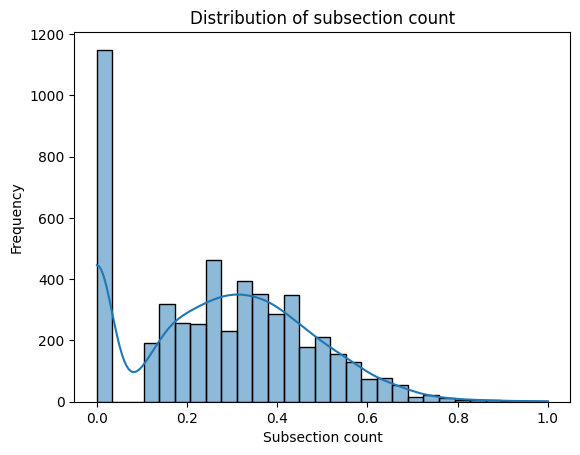

In [56]:
# Subsection count
sns.histplot(df_transformed['subsection_count'], kde=True)

plt.title('Distribution of subsection count')
plt.xlabel('Subsection count')
plt.ylabel('Frequency')
plt.show()

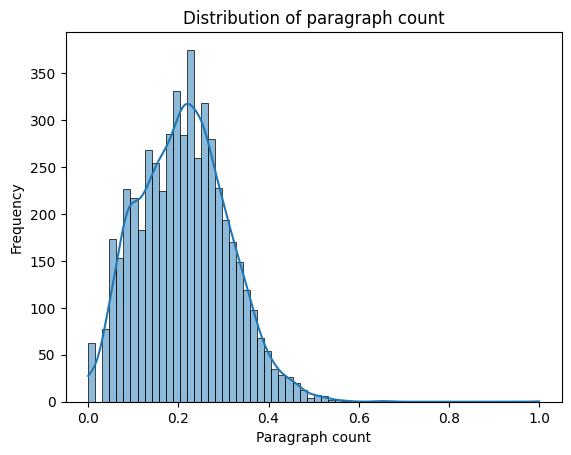

In [57]:
# Paragraph count
sns.histplot(df_transformed['paragraph_count'], kde=True)

plt.title('Distribution of paragraph count')
plt.xlabel('Paragraph count')
plt.ylabel('Frequency')
plt.show()

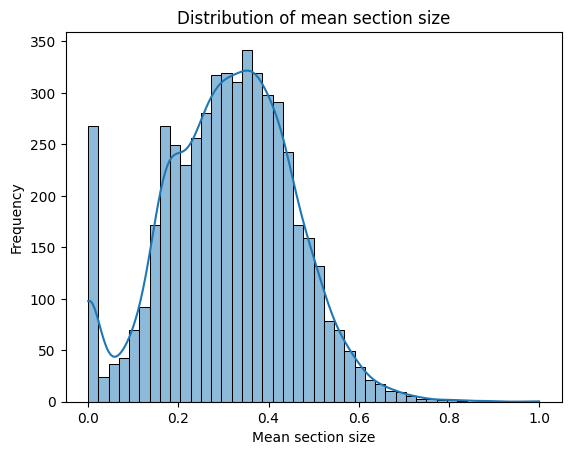

In [58]:
# Mean section size
sns.histplot(df_transformed['mean_section_size'], kde=True)

plt.title('Distribution of mean section size')
plt.xlabel('Mean section size')
plt.ylabel('Frequency')
plt.show()

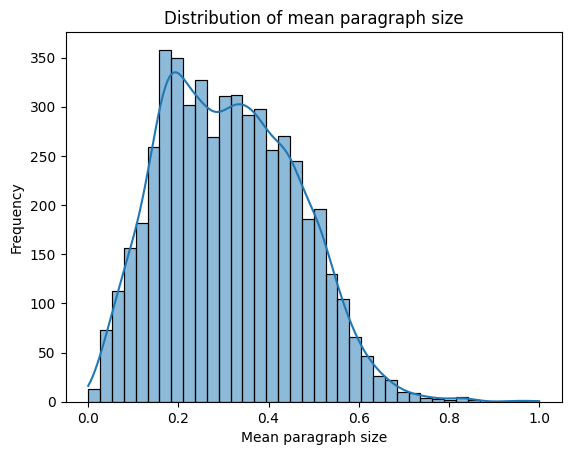

In [59]:
# Mean paragraph size
sns.histplot(df_transformed['mean_paragraph_size'], kde=True)

plt.title('Distribution of mean paragraph size')
plt.xlabel('Mean paragraph size')
plt.ylabel('Frequency')
plt.show()

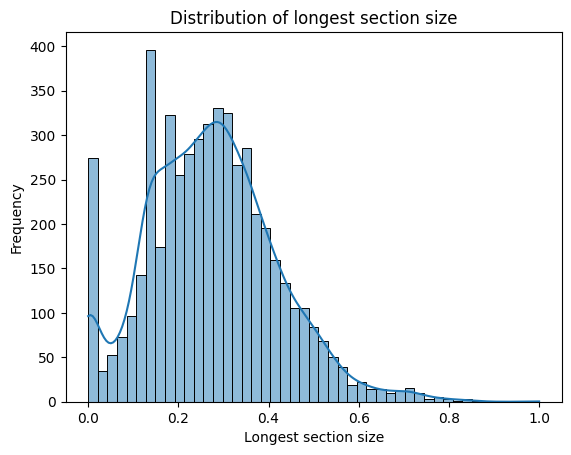

In [60]:
# Longest section size
sns.histplot(df_transformed['longest_section_size'], kde=True)

plt.title('Distribution of longest section size')
plt.xlabel('Longest section size')
plt.ylabel('Frequency')
plt.show()

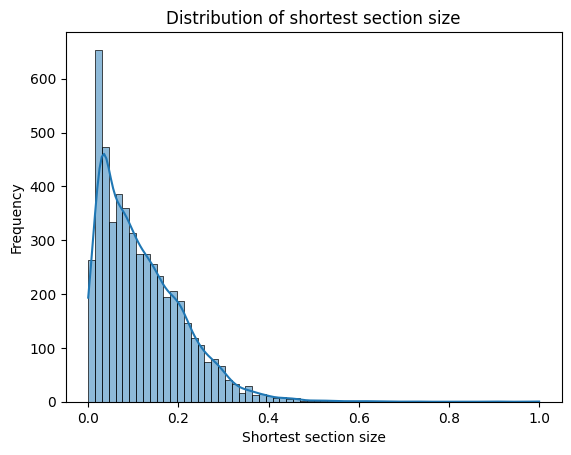

In [61]:
# Shortest section size
sns.histplot(df_transformed['shortest_section_size'], kde=True)

plt.title('Distribution of shortest section size')
plt.xlabel('Shortest section size')
plt.ylabel('Frequency')
plt.show()

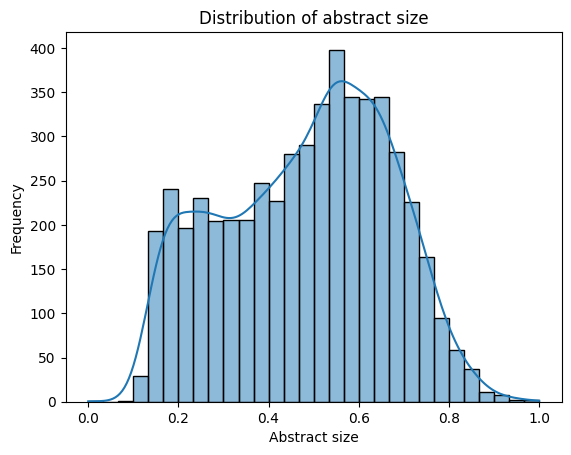

In [62]:
# Abstract size
sns.histplot(df_transformed['abstract_size'], kde=True)

plt.title('Distribution of abstract size')
plt.xlabel('Abstract size')
plt.ylabel('Frequency')
plt.show()

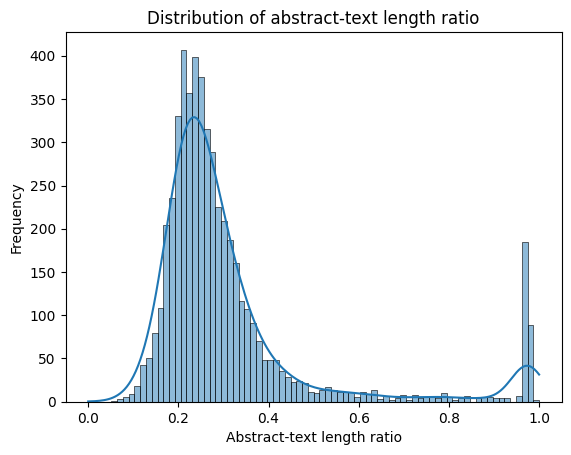

In [63]:
# Abstract-text length ratio
sns.histplot(df_transformed['abstract_text_ratio'], kde=True)

plt.title('Distribution of abstract-text length ratio')
plt.xlabel('Abstract-text length ratio')
plt.ylabel('Frequency')
plt.show()

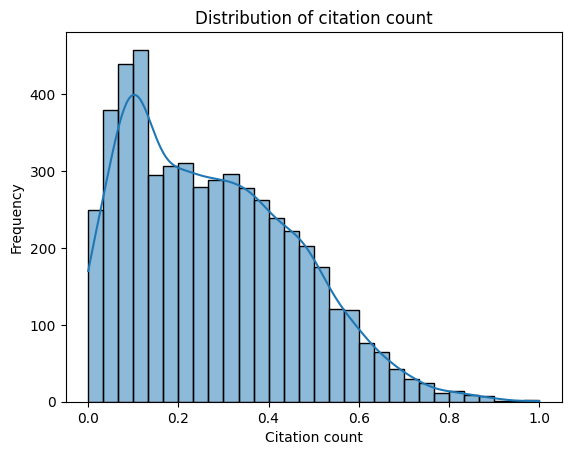

In [64]:
# Citation count
sns.histplot(df_transformed['citation_count'], kde=True)

plt.title('Distribution of citation count')
plt.xlabel('Citation count')
plt.ylabel('Frequency')
plt.show()

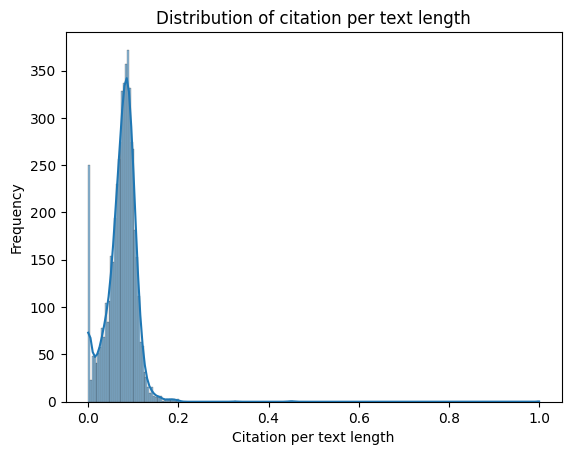

In [65]:
# Citation per text length
sns.histplot(df_transformed['citation_per_text'], kde=True)

plt.title('Distribution of citation per text length')
plt.xlabel('Citation per text length')
plt.ylabel('Frequency')
plt.show()

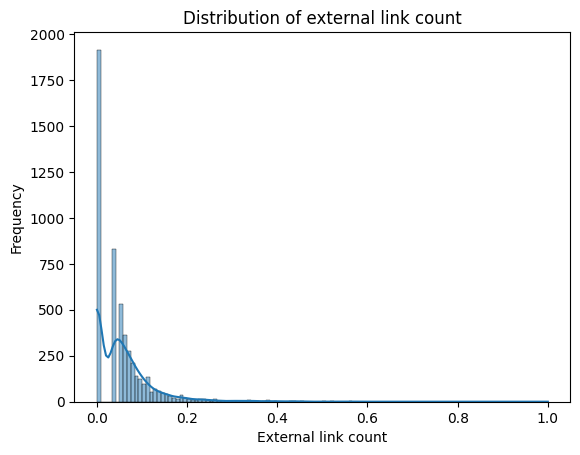

In [66]:
# External link count
sns.histplot(df_transformed['external_link_count'], kde=True)

plt.title('Distribution of external link count')
plt.xlabel('External link count')
plt.ylabel('Frequency')
plt.show()

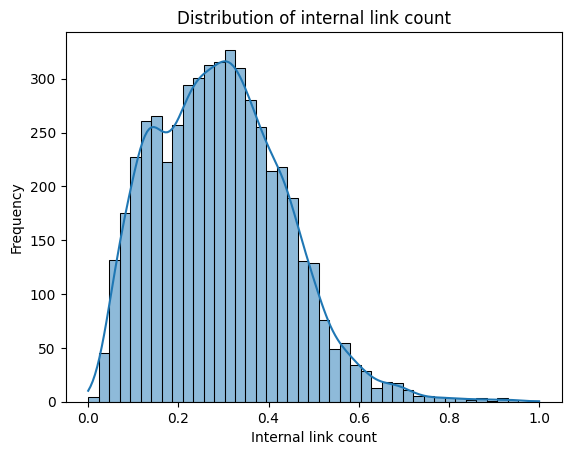

In [67]:
# Internal link count
sns.histplot(df_transformed['internal_link_count'], kde=True)

plt.title('Distribution of internal link count')
plt.xlabel('Internal link count')
plt.ylabel('Frequency')
plt.show()

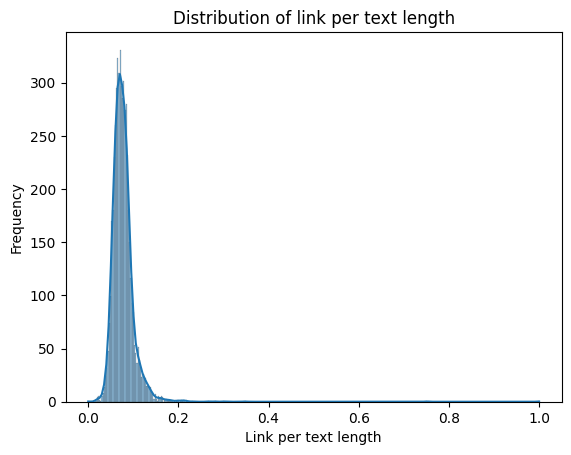

In [68]:
# Link per text length
sns.histplot(df_transformed['link_per_text'], kde=True)

plt.title('Distribution of link per text length')
plt.xlabel('Link per text length')
plt.ylabel('Frequency')
plt.show()

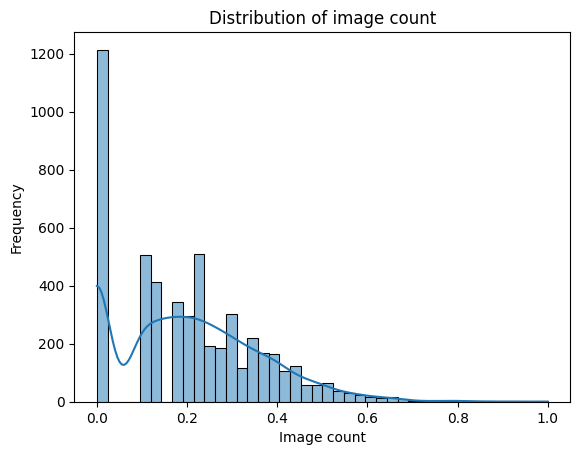

In [69]:
# Image count
sns.histplot(df_transformed['image_count'], kde=True)

plt.title('Distribution of image count')
plt.xlabel('Image count')
plt.ylabel('Frequency')
plt.show()

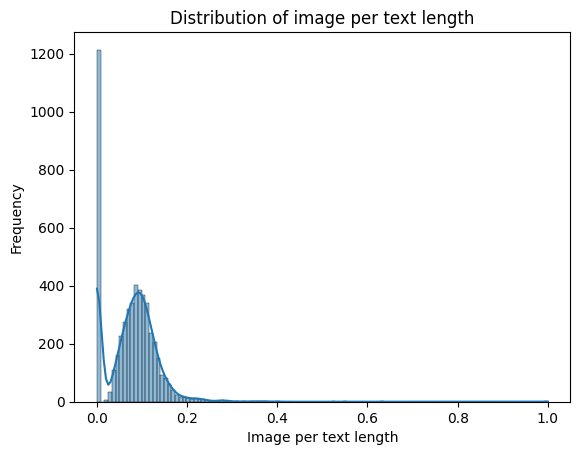

In [70]:
# Image per text length
sns.histplot(df_transformed['image_per_text'], kde=True)

plt.title('Distribution of image per text length')
plt.xlabel('Image per text length')
plt.ylabel('Frequency')
plt.show()

__style features__

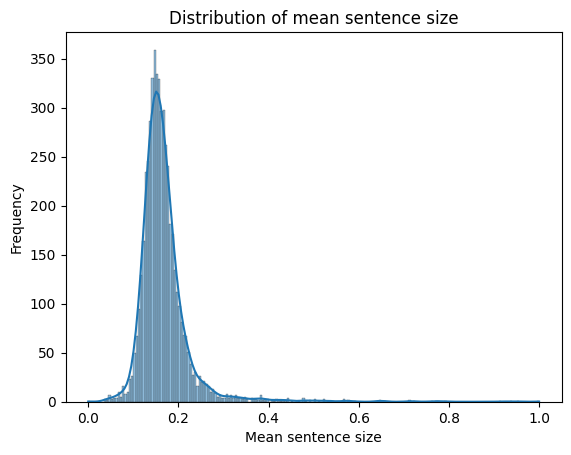

In [71]:
# Mean sentence size
sns.histplot(df_transformed['mean_sentence_size'], kde=True)

plt.title('Distribution of mean sentence size')
plt.xlabel('Mean sentence size')
plt.ylabel('Frequency')
plt.show()

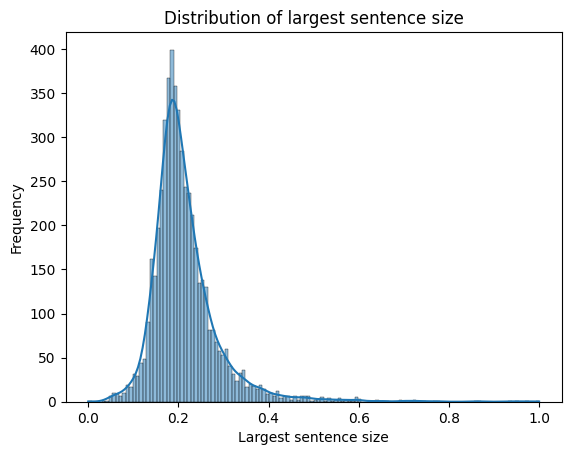

In [72]:
# Largest sentence size
sns.histplot(df_transformed['largest_sentence_size'], kde=True)

plt.title('Distribution of largest sentence size')
plt.xlabel('Largest sentence size')
plt.ylabel('Frequency')
plt.show()

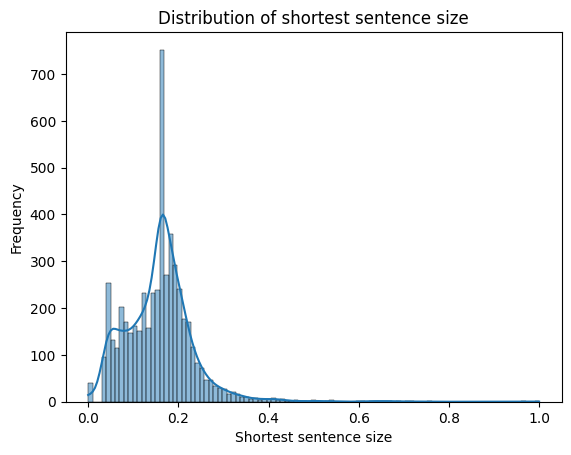

In [73]:
# Shortest sentence size
sns.histplot(df_transformed['shortest_sentence_size'], kde=True)

plt.title('Distribution of shortest sentence size')
plt.xlabel('Shortest sentence size')
plt.ylabel('Frequency')
plt.show()

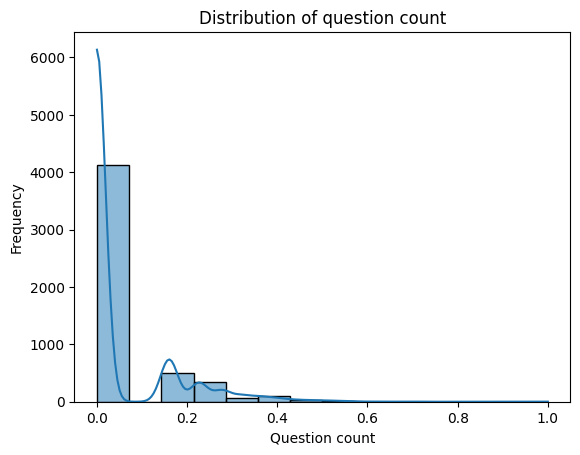

In [74]:
# Question count
sns.histplot(df_transformed['question_count'], kde=True)

plt.title('Distribution of question count')
plt.xlabel('Question count')
plt.ylabel('Frequency')
plt.show()

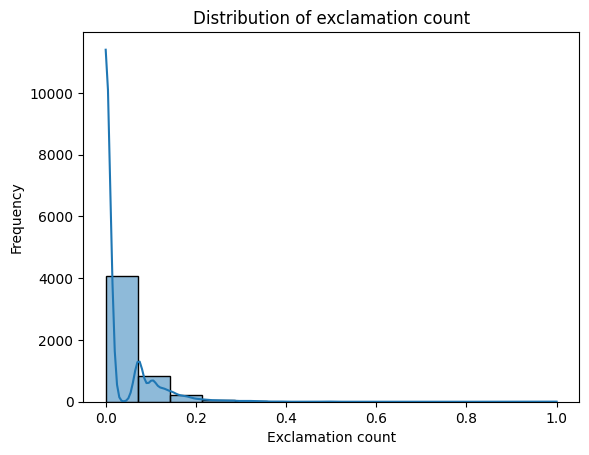

In [75]:
# Exclamation count
sns.histplot(df_transformed['exclamation_count'], kde=True)

plt.title('Distribution of exclamation count')
plt.xlabel('Exclamation count')
plt.ylabel('Frequency')
plt.show()

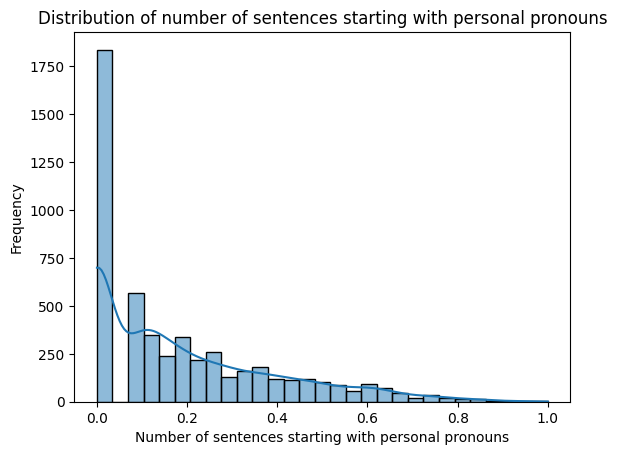

In [76]:
# Number of sentences starting with personal pronouns
sns.histplot(df_transformed['pronoun_start_count'], kde=True)

plt.title('Distribution of number of sentences starting with personal pronouns')
plt.xlabel('Number of sentences starting with personal pronouns')
plt.ylabel('Frequency')
plt.show()

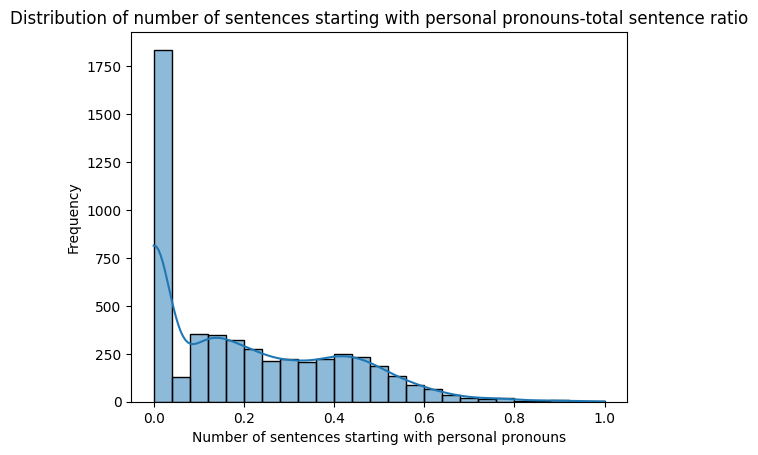

In [77]:
# Number of sentences starting with personal pronouns-total sentence ratio
sns.histplot(df_transformed['pronoun_start_count_sentence_ratio'], kde=True)

plt.title('Distribution of number of sentences starting with personal pronouns-total sentence ratio')
plt.xlabel('Number of sentences starting with personal pronouns')
plt.ylabel('Frequency')
plt.show()

__edit features__

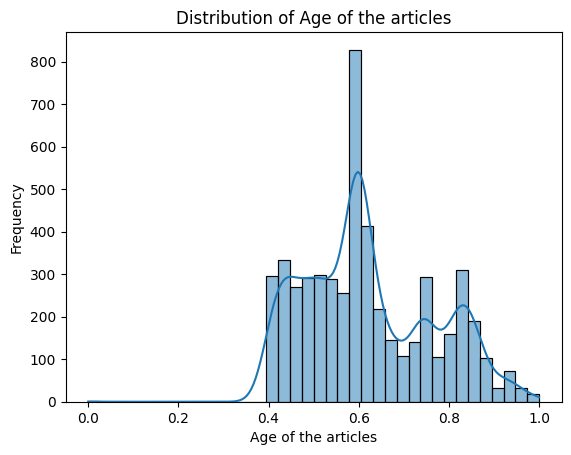

In [78]:
# Age of the articles
sns.histplot(df_transformed['article_age_days'], kde=True)

plt.title('Distribution of Age of the articles')
plt.xlabel('Age of the articles')
plt.ylabel('Frequency')
plt.show()

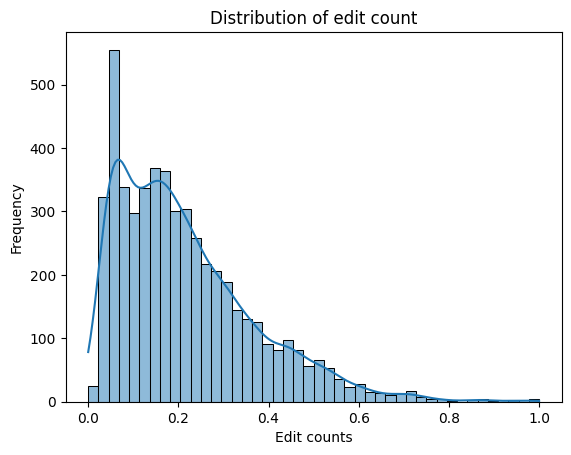

In [79]:
# Edit count
sns.histplot(df_transformed['num_edits'], kde=True)

plt.title('Distribution of edit count')
plt.xlabel('Edit counts')
plt.ylabel('Frequency')
plt.show()

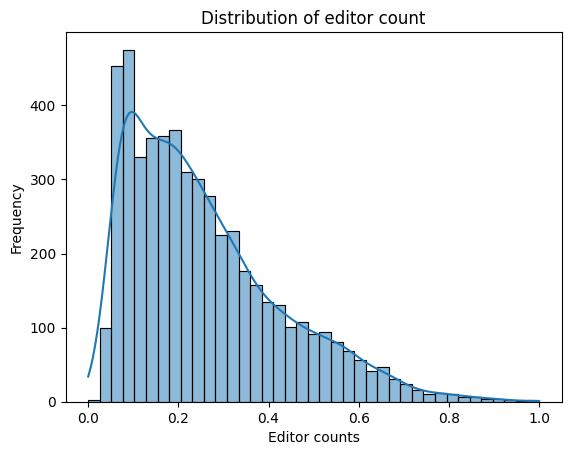

In [80]:
# Editor count
sns.histplot(df_transformed['num_editors'], kde=True)

plt.title('Distribution of editor count')
plt.xlabel('Editor counts')
plt.ylabel('Frequency')
plt.show()

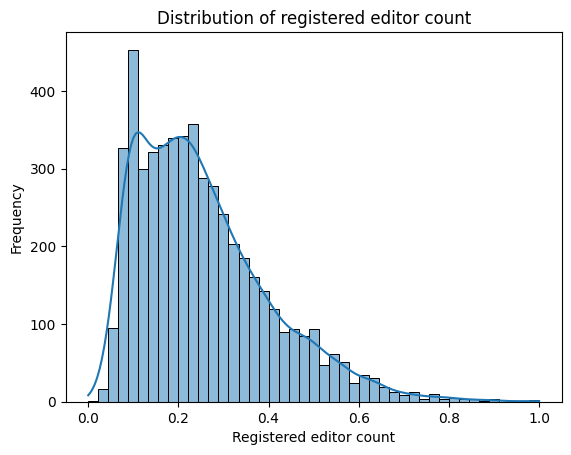

In [81]:
# Registered editor count
sns.histplot(df_transformed['num_registered_editors'], kde=True)

plt.title('Distribution of registered editor count')
plt.xlabel('Registered editor count')
plt.ylabel('Frequency')
plt.show()

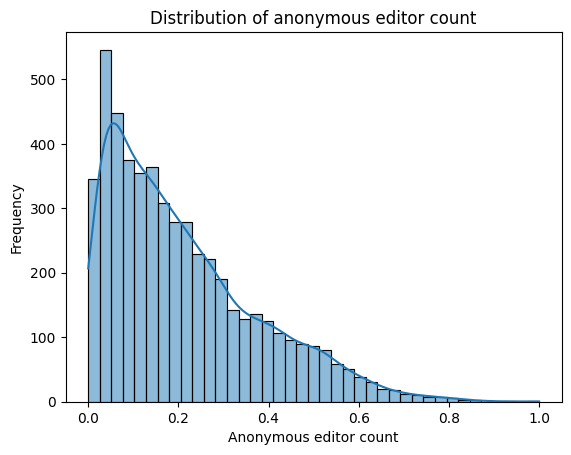

In [82]:
# Anonymous editor count
sns.histplot(df_transformed['num_anonymous_editors'], kde=True)

plt.title('Distribution of anonymous editor count')
plt.xlabel('Anonymous editor count')
plt.ylabel('Frequency')
plt.show()

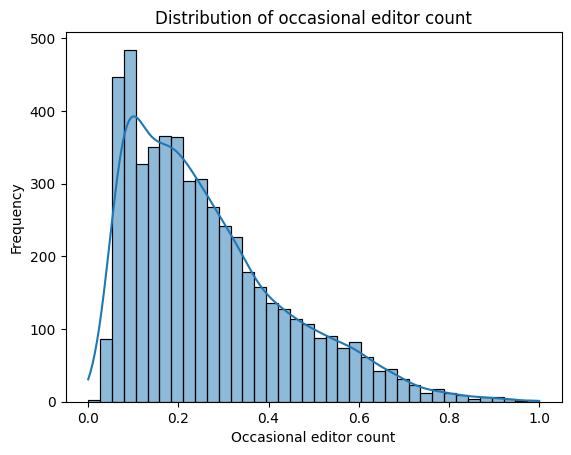

In [83]:
# Occasional editor count
sns.histplot(df_transformed['num_occasional_editors'], kde=True)

plt.title('Distribution of occasional editor count')
plt.xlabel('Occasional editor count')
plt.ylabel('Frequency')
plt.show()

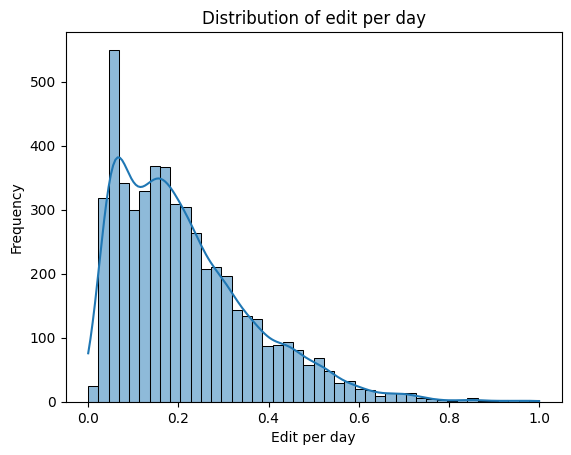

In [84]:
# Edit per day
sns.histplot(df_transformed['edit_per_day'], kde=True)

plt.title('Distribution of edit per day')
plt.xlabel('Edit per day')
plt.ylabel('Frequency')
plt.show()

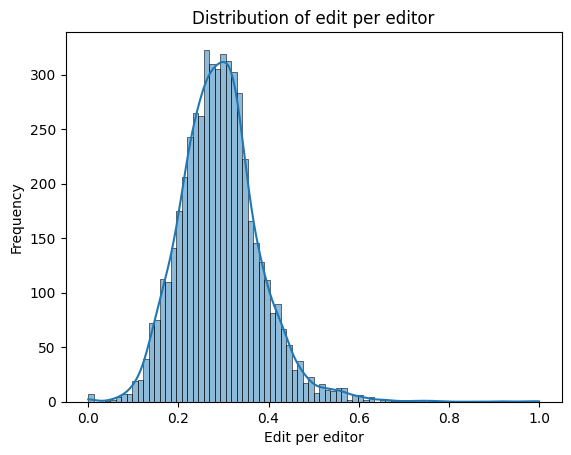

In [85]:
# Edit per editor
sns.histplot(df_transformed['edit_per_editor'], kde=True)

plt.title('Distribution of edit per editor')
plt.xlabel('Edit per editor')
plt.ylabel('Frequency')
plt.show()

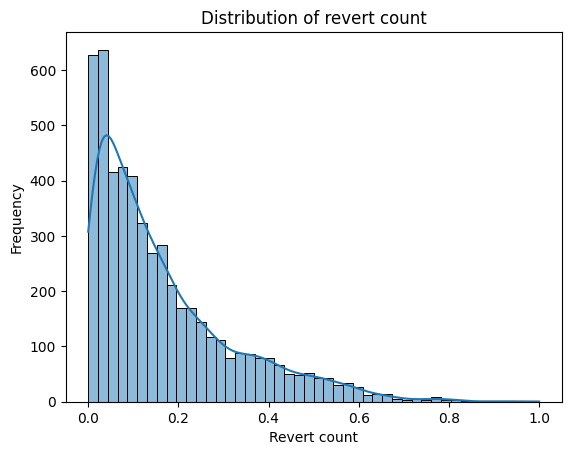

In [86]:
# Revert count
sns.histplot(df_transformed['revert_count'], kde=True)

plt.title('Distribution of revert count')
plt.xlabel('Revert count')
plt.ylabel('Frequency')
plt.show()

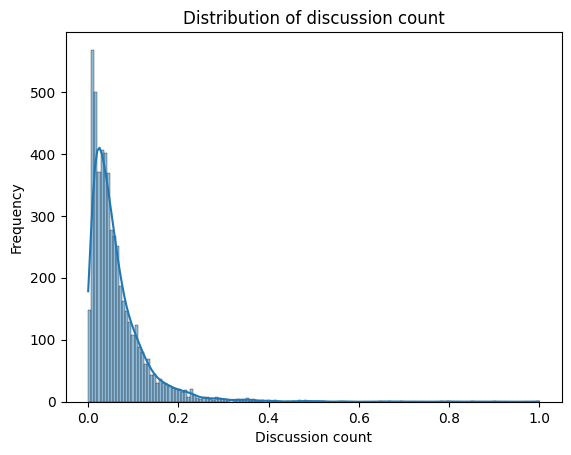

In [87]:
# Discussion count
sns.histplot(df_transformed['discussion_count'], kde=True)

plt.title('Distribution of discussion count')
plt.xlabel('Discussion count')
plt.ylabel('Frequency')
plt.show()

### Modelling

__all transformed features included__

In [50]:
# Results when all features are included
X = df_transformed.iloc[:, 2:-1]
y = df_transformed['quality']

result1 = train_and_evaluate_models(X, y)
result1

,Model,CV Accuracy,CV Precision,CV Recall,CV F1 Score,Test Accuracy,Test Precision,Test Recall,Test F1 Score
0,Logistic Regression,0.883894,0.884514,0.883894,0.883850,0.897115,0.897894,0.897115,0.897065
1,SVM,0.891346,0.892566,0.891346,0.891263,0.906731,0.908582,0.906731,0.906625
2,Random Forest,0.894471,0.893902,0.894952,0.895386,0.897115,0.897646,0.897115,0.897081
3,AdaBoost,0.887740,0.888689,0.887740,0.887671,0.888462,0.888743,0.888462,0.888441
4,XGBoost,0.902644,0.903332,0.902644,0.902601,0.904808,0.905145,0.904808,0.904788
5,MLP,0.895673,0.893546,0.892308,0.896319,0.900962,0.901498,0.900962,0.900928
6,KNN,0.864183,0.870604,0.864183,0.863588,0.880769,0.885566,0.880769,0.880397


__selected transformed features__

In [97]:
structure_style_edit = df_transformed.iloc[:, list(range(0, 2))+list(range(7, 31))+list(range(38, 48)) + [-1]]
structure_style_edit

,title,page_id,section_count,subsection_count,paragraph_count,mean_section_size,mean_paragraph_size,longest_section_size,shortest_section_size,abstract_size,...,num_edits,num_editors,num_registered_editors,num_anonymous_editors,num_occasional_editors,edit_per_day,edit_per_editor,revert_count,discussion_count,quality
0,Mayan languages,182013,0.423207,0.559017,0.302545,0.414871,0.296921,0.296766,0.156032,0.594800,...,0.300793,0.312934,0.305814,0.264060,0.324323,0.304021,0.397087,0.265847,0.119514,1
1,Mu'awiya I,207068,0.457116,0.460977,0.290978,0.514163,0.590486,0.382017,0.229040,0.785883,...,0.375636,0.403067,0.363574,0.370363,0.408188,0.381012,0.379398,0.350408,0.171517,1
2,The Fountainhead,180464,0.405190,0.512348,0.246253,0.425948,0.443358,0.308449,0.104116,0.644859,...,0.287712,0.360744,0.312363,0.343128,0.377240,0.290727,0.291219,0.197049,0.081021,1
3,Northern pintail,218361,0.345547,0.158114,0.172477,0.289965,0.316496,0.165883,0.206174,0.531549,...,0.164631,0.209598,0.237224,0.133821,0.220154,0.167240,0.281745,0.121020,0.039753,1
4,Manhattan Project,19603,0.610847,0.622495,0.410112,0.475590,0.444961,0.463620,0.179247,0.738229,...,0.479101,0.559328,0.508431,0.510137,0.580954,0.467709,0.331428,0.435170,0.160250,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5195,Party of Democratic Kampuchea,265468,0.172774,0.000000,0.082855,0.000000,0.172201,0.000000,0.000000,0.578849,...,0.054513,0.075391,0.086544,0.047814,0.077718,0.055707,0.228880,0.022603,0.017433,0
5196,Minawara and Multultu,95240,0.122169,0.000000,0.000000,0.000000,0.271028,0.000000,0.000000,0.270141,...,0.031662,0.053310,0.068234,0.019520,0.059461,0.031726,0.115314,0.013050,0.005513,0
5197,Theophylline/ephedra/hydroxyzine,262652,0.122169,0.000000,0.000000,0.000000,0.178390,0.000000,0.000000,0.221093,...,0.037368,0.058600,0.072548,0.027605,0.063068,0.038227,0.157962,0.018455,0.005513,0
5198,"Channel Lake, Illinois",111450,0.211604,0.158114,0.082855,0.206236,0.212284,0.136928,0.142583,0.178105,...,0.048611,0.070522,0.089984,0.023907,0.073830,0.048776,0.202543,0.000000,0.011026,0


In [89]:
# Results when all features are included
X = structure_style_edit.iloc[:, 2:-1]
y = structure_style_edit['quality']

result2 = train_and_evaluate_models(X, y)
result2

,Model,CV Accuracy,CV Precision,CV Recall,CV F1 Score,Test Accuracy,Test Precision,Test Recall,Test F1 Score
0,Logistic Regression,0.877885,0.878624,0.877885,0.877827,0.889423,0.890186,0.889423,0.889369
1,SVM,0.885337,0.887003,0.885337,0.885215,0.899038,0.901535,0.899038,0.898881
2,Random Forest,0.892788,0.896831,0.894712,0.891771,0.897115,0.897446,0.897115,0.897094
3,AdaBoost,0.888702,0.889846,0.888702,0.888620,0.891346,0.891765,0.891346,0.891317
4,XGBoost,0.904808,0.905456,0.904808,0.904770,0.903846,0.904444,0.903846,0.903811
5,MLP,0.891106,0.895107,0.890385,0.890950,0.905769,0.906497,0.905769,0.905727
6,KNN,0.862740,0.867932,0.862740,0.862248,0.863462,0.867424,0.863462,0.863092


__selected features+doc2vec__

In [90]:
doc2vec = pd.read_csv('/content/drive/MyDrive/학교/Dissertation/Dissertation_final/Feature Extraction/doc2vec_features.csv')
doc2vec

,title,page_id,doc2vec_20,doc2vec_50,doc2vec_100,doc2vec_200,doc2vec_300,doc2vec_500,quality
0,Mayan languages,182013,[-0.11873353 -2.4407356 -1.3702062 3.105298...,[ 0.14162295 -0.73532563 -1.8102438 -0.719203...,[ 0.21416852 -1.6696423 1.1597384 1.677749...,[-0.92931765 0.35427883 -0.985394 0.967223...,[-1.2080181 -0.70352554 -1.3096839 0.218799...,[-1.08123168e-01 -5.05179107e-01 -4.73065108e-...,1
1,Mu'awiya I,207068,[-2.07483 -1.4922532 0.36730346 3.651323...,[-0.94526184 -0.3110869 -1.9218819 -0.398054...,[-1.74806 -1.1632584 0.10795426 0.813521...,[-9.32636440e-01 -1.48135829e+00 1.86571255e-...,[ 0.1324497 -0.15933883 -0.56959057 0.640978...,[-1.1343669 -0.30720899 0.24345188 0.244366...,1
2,The Fountainhead,180464,[-0.939232 -2.142721 -1.883358 -0.108726...,[-0.89889634 -1.2338424 -0.1994613 1.074865...,[-1.2348349 -0.80121356 -0.1178944 -0.153580...,[-0.18963027 -0.5407947 0.02293755 0.160935...,[-3.95752490e-01 -2.72289246e-01 -4.50629920e-...,[ 4.51237231e-01 -3.93101126e-01 1.52836084e-...,1
3,Northern pintail,218361,[ 0.22895382 -0.07847051 -2.0693347 1.151979...,[-1.9152571 -0.9863042 -0.31720063 0.676733...,[-1.052102 -2.012778 0.20379645 -0.846639...,[-1.0868081 -1.1545188 -0.75203115 -0.079450...,[-0.15325828 -1.0265552 -0.950474 -0.276538...,[-2.55974084e-01 -1.00488138e+00 -7.53050864e-...,1
4,Manhattan Project,19603,[-0.41071716 -0.91254836 -3.3086228 0.386623...,[-0.08591695 -1.153746 -1.1509885 0.584178...,[-1.3185098 -1.2019124 0.5035422 0.113358...,[-1.0916361 -1.0232843 0.73881316 0.130395...,[ 1.85518786e-01 8.67399991e-01 -3.50051463e-...,[-2.31942884e-03 -4.61694479e-01 3.10965121e-...,1
...,...,...,...,...,...,...,...,...,...
5195,Party of Democratic Kampuchea,265468,[-0.49925566 -0.5244077 -0.9469565 1.450050...,[-0.78056765 0.6843561 -1.1771741 0.382591...,[ 0.488909 -0.54169947 -0.3533258 0.162753...,[-2.64059007e-01 -4.53496762e-02 -6.67918384e-...,[-5.84085286e-01 6.87814727e-02 -3.03456843e-...,[-1.30619839e-01 -1.23517677e-01 2.14104261e-...,0
5196,Minawara and Multultu,95240,[-0.69623053 -0.28086147 -0.49423888 0.373790...,[-0.5233514 -0.5955352 -0.45576015 -0.262624...,[-3.48152429e-01 -5.32957375e-01 -1.07259654e-...,[-0.15931535 -0.45631117 -0.14412077 0.047031...,[-0.1366955 -0.18754531 -0.12493268 -0.018171...,[-1.55988351e-01 -9.39027667e-02 -5.48811592e-...,0
5197,Theophylline/ephedra/hydroxyzine,262652,[-0.55075014 -0.13917734 -0.75503784 0.880972...,[-0.5035148 -0.2839609 -0.3405831 0.169453...,[-2.67971367e-01 -4.94407803e-01 -1.63930863e-...,[-1.67261347e-01 -8.01966190e-02 -2.56586194e-...,[-1.96540684e-01 -6.82713836e-02 -1.28727436e-...,[-0.05836337 0.03332838 -0.02910833 0.038263...,0
5198,"Channel Lake, Illinois",111450,[-2.5712607 -0.99652314 -2.6514347 0.483577...,[-1.2923265 -0.7806829 -1.1711309 0.212995...,[-0.6354738 -0.79841405 0.05622012 0.378250...,[-9.76243198e-01 -6.22522295e-01 -4.92107987e-...,[-0.37194127 -0.10045881 -0.15332541 -0.275343...,[-1.61765054e-01 3.33138444e-02 -8.17700550e-...,0


In [91]:
# Function to process doc2vec columns
def clean_and_convert_vector(vector_str):
    # Remove newline characters and extra spaces
    cleaned_str = vector_str.replace('\n', ' ').replace('  ', ' ').strip()
    # Convert the cleaned string to a numpy array
    return np.fromstring(cleaned_str.strip('[]'), sep=' ')

In [92]:
doc2vec['doc2vec_20'] = doc2vec['doc2vec_20'].apply(clean_and_convert_vector)

In [93]:
# Create features using doc2vec_20
df_20 = doc2vec.copy()
df_20 = df_20[['title', 'page_id', 'doc2vec_20', 'quality']]

vector_columns = pd.DataFrame(df_20['doc2vec_20'].tolist(), columns=[f'var_{i+1}' for i in range(20)])
df_20 = df_20.join(vector_columns)
df_20

,title,page_id,doc2vec_20,quality,var_1,var_2,var_3,var_4,var_5,var_6,...,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20
0,Mayan languages,182013,"[-0.11873353, -2.4407356, -1.3702062, 3.105298...",1,-0.118734,-2.440736,-1.370206,3.105298,0.444223,1.270455,...,2.589589,-3.304577,-0.880189,0.132373,-1.697009,-1.738696,0.542941,0.903049,-1.734197,0.417213
1,Mu'awiya I,207068,"[-2.07483, -1.4922532, 0.36730346, 3.6513238, ...",1,-2.074830,-1.492253,0.367303,3.651324,1.235692,-0.449774,...,1.648793,0.241381,-0.366885,-0.707308,-2.055417,-1.595411,1.199849,-2.256915,-1.318837,-0.628533
2,The Fountainhead,180464,"[-0.939232, -2.142721, -1.883358, -0.10872623,...",1,-0.939232,-2.142721,-1.883358,-0.108726,1.719563,-1.276436,...,-0.990515,0.894514,-0.850906,-1.573790,-0.939912,0.271126,0.087762,0.493070,-0.744864,0.943934
3,Northern pintail,218361,"[0.22895382, -0.07847051, -2.0693347, 1.151979...",1,0.228954,-0.078471,-2.069335,1.151980,-0.904061,-0.028492,...,-0.217106,-0.038556,-2.535328,-1.079626,0.984010,-3.052293,-1.283746,0.150716,-2.270509,0.511353
4,Manhattan Project,19603,"[-0.41071716, -0.91254836, -3.3086228, 0.38662...",1,-0.410717,-0.912548,-3.308623,0.386624,2.255983,0.510913,...,-0.649519,1.573444,0.557071,-1.295349,1.095210,-0.513653,-0.424813,0.191953,-2.206298,-0.896591
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5195,Party of Democratic Kampuchea,265468,"[-0.49925566, -0.5244077, -0.9469565, 1.450050...",0,-0.499256,-0.524408,-0.946956,1.450051,0.232176,0.072388,...,1.364483,1.565599,-0.117768,-0.553074,-1.408595,-1.481983,0.412338,-0.264874,-1.365068,-1.363219
5196,Minawara and Multultu,95240,"[-0.69623053, -0.28086147, -0.49423888, 0.3737...",0,-0.696231,-0.280861,-0.494239,0.373790,0.157850,0.087360,...,-0.029130,0.056235,-1.061213,0.044772,-0.044322,-0.851839,-0.056814,0.286022,-0.846064,-0.032695
5197,Theophylline/ephedra/hydroxyzine,262652,"[-0.55075014, -0.13917734, -0.75503784, 0.8809...",0,-0.550750,-0.139177,-0.755038,0.880972,0.098353,0.048484,...,0.014874,0.138150,-0.292356,-0.286313,-0.223987,-0.202073,-0.371795,0.419180,-0.500988,-0.126529
5198,"Channel Lake, Illinois",111450,"[-2.5712607, -0.99652314, -2.6514347, 0.483577...",0,-2.571261,-0.996523,-2.651435,0.483577,0.259311,-0.176672,...,1.413022,1.097628,-1.258792,0.260787,-0.695690,-1.898501,-1.764783,0.649597,-1.145714,-0.401934


In [98]:
# Combine all text features with doc2vec_20
combined_20 = structure_style_edit.merge(df_20, on='title')
combined_20

,title,page_id_x,section_count,subsection_count,paragraph_count,mean_section_size,mean_paragraph_size,longest_section_size,shortest_section_size,abstract_size,...,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20
0,Mayan languages,182013,0.423207,0.559017,0.302545,0.414871,0.296921,0.296766,0.156032,0.594800,...,2.589589,-3.304577,-0.880189,0.132373,-1.697009,-1.738696,0.542941,0.903049,-1.734197,0.417213
1,Mu'awiya I,207068,0.457116,0.460977,0.290978,0.514163,0.590486,0.382017,0.229040,0.785883,...,1.648793,0.241381,-0.366885,-0.707308,-2.055417,-1.595411,1.199849,-2.256915,-1.318837,-0.628533
2,The Fountainhead,180464,0.405190,0.512348,0.246253,0.425948,0.443358,0.308449,0.104116,0.644859,...,-0.990515,0.894514,-0.850906,-1.573790,-0.939912,0.271126,0.087762,0.493070,-0.744864,0.943934
3,Northern pintail,218361,0.345547,0.158114,0.172477,0.289965,0.316496,0.165883,0.206174,0.531549,...,-0.217106,-0.038556,-2.535328,-1.079626,0.984010,-3.052293,-1.283746,0.150716,-2.270509,0.511353
4,Manhattan Project,19603,0.610847,0.622495,0.410112,0.475590,0.444961,0.463620,0.179247,0.738229,...,-0.649519,1.573444,0.557071,-1.295349,1.095210,-0.513653,-0.424813,0.191953,-2.206298,-0.896591
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5195,Party of Democratic Kampuchea,265468,0.172774,0.000000,0.082855,0.000000,0.172201,0.000000,0.000000,0.578849,...,1.364483,1.565599,-0.117768,-0.553074,-1.408595,-1.481983,0.412338,-0.264874,-1.365068,-1.363219
5196,Minawara and Multultu,95240,0.122169,0.000000,0.000000,0.000000,0.271028,0.000000,0.000000,0.270141,...,-0.029130,0.056235,-1.061213,0.044772,-0.044322,-0.851839,-0.056814,0.286022,-0.846064,-0.032695
5197,Theophylline/ephedra/hydroxyzine,262652,0.122169,0.000000,0.000000,0.000000,0.178390,0.000000,0.000000,0.221093,...,0.014874,0.138150,-0.292356,-0.286313,-0.223987,-0.202073,-0.371795,0.419180,-0.500988,-0.126529
5198,"Channel Lake, Illinois",111450,0.211604,0.158114,0.082855,0.206236,0.212284,0.136928,0.142583,0.178105,...,1.413022,1.097628,-1.258792,0.260787,-0.695690,-1.898501,-1.764783,0.649597,-1.145714,-0.401934


In [99]:
combined_20.drop(['page_id_y', 'quality_y', 'doc2vec_20'], axis=1, inplace=True)
combined_20.rename(columns={'page_id_x': 'page_id', 'quality_x': 'quality'}, inplace=True)
combined_20

,title,page_id,section_count,subsection_count,paragraph_count,mean_section_size,mean_paragraph_size,longest_section_size,shortest_section_size,abstract_size,...,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20
0,Mayan languages,182013,0.423207,0.559017,0.302545,0.414871,0.296921,0.296766,0.156032,0.594800,...,2.589589,-3.304577,-0.880189,0.132373,-1.697009,-1.738696,0.542941,0.903049,-1.734197,0.417213
1,Mu'awiya I,207068,0.457116,0.460977,0.290978,0.514163,0.590486,0.382017,0.229040,0.785883,...,1.648793,0.241381,-0.366885,-0.707308,-2.055417,-1.595411,1.199849,-2.256915,-1.318837,-0.628533
2,The Fountainhead,180464,0.405190,0.512348,0.246253,0.425948,0.443358,0.308449,0.104116,0.644859,...,-0.990515,0.894514,-0.850906,-1.573790,-0.939912,0.271126,0.087762,0.493070,-0.744864,0.943934
3,Northern pintail,218361,0.345547,0.158114,0.172477,0.289965,0.316496,0.165883,0.206174,0.531549,...,-0.217106,-0.038556,-2.535328,-1.079626,0.984010,-3.052293,-1.283746,0.150716,-2.270509,0.511353
4,Manhattan Project,19603,0.610847,0.622495,0.410112,0.475590,0.444961,0.463620,0.179247,0.738229,...,-0.649519,1.573444,0.557071,-1.295349,1.095210,-0.513653,-0.424813,0.191953,-2.206298,-0.896591
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5195,Party of Democratic Kampuchea,265468,0.172774,0.000000,0.082855,0.000000,0.172201,0.000000,0.000000,0.578849,...,1.364483,1.565599,-0.117768,-0.553074,-1.408595,-1.481983,0.412338,-0.264874,-1.365068,-1.363219
5196,Minawara and Multultu,95240,0.122169,0.000000,0.000000,0.000000,0.271028,0.000000,0.000000,0.270141,...,-0.029130,0.056235,-1.061213,0.044772,-0.044322,-0.851839,-0.056814,0.286022,-0.846064,-0.032695
5197,Theophylline/ephedra/hydroxyzine,262652,0.122169,0.000000,0.000000,0.000000,0.178390,0.000000,0.000000,0.221093,...,0.014874,0.138150,-0.292356,-0.286313,-0.223987,-0.202073,-0.371795,0.419180,-0.500988,-0.126529
5198,"Channel Lake, Illinois",111450,0.211604,0.158114,0.082855,0.206236,0.212284,0.136928,0.142583,0.178105,...,1.413022,1.097628,-1.258792,0.260787,-0.695690,-1.898501,-1.764783,0.649597,-1.145714,-0.401934


In [100]:
X = combined_20.drop(['title', 'page_id', 'quality'], axis=1)
y = combined_20['quality']

result3 = train_and_evaluate_models(X, y)
result3

,Model,CV Accuracy,CV Precision,CV Recall,CV F1 Score,Test Accuracy,Test Precision,Test Recall,Test F1 Score
0,Logistic Regression,0.888942,0.889493,0.888942,0.888903,0.900000,0.901163,0.900000,0.899927
1,SVM,0.854808,0.858115,0.854808,0.854463,0.883654,0.886549,0.883654,0.883436
2,Random Forest,0.896875,0.896202,0.898077,0.894164,0.900000,0.901003,0.900000,0.899937
3,AdaBoost,0.890385,0.890962,0.890385,0.890343,0.883654,0.883667,0.883654,0.883653
4,XGBoost,0.912260,0.912991,0.912260,0.912222,0.913462,0.913682,0.913462,0.913450
5,MLP,0.894231,0.888961,0.897837,0.886038,0.903846,0.904708,0.903846,0.903795
6,KNN,0.808173,0.812429,0.808173,0.807502,0.826923,0.829502,0.826923,0.826584


__log transformed for selected features__

In [107]:
df_selected = df_scaled.copy()
df_selected = df_selected.iloc[:, list(range(0, 2))+list(range(7, 31))+list(range(38, 48)) + [-1]]
#df_selected = df.copy()

columns_to_exclude = ['title', 'page_id', 'infobox', 'quality']
columns_to_transform = df_selected.columns.difference(columns_to_exclude)

#df_selected[columns_to_transform] = df_selected[columns_to_transform].apply(lambda x: np.log(x))
df_selected[columns_to_transform] = df_selected[columns_to_transform].apply(lambda x: np.sqrt(x))
df_selected

,title,page_id,section_count,subsection_count,paragraph_count,mean_section_size,mean_paragraph_size,longest_section_size,shortest_section_size,abstract_size,...,num_edits,num_editors,num_registered_editors,num_anonymous_editors,num_occasional_editors,edit_per_day,edit_per_editor,revert_count,discussion_count,quality
0,Mayan languages,182013,0.423207,0.559017,0.302545,0.414871,0.544905,0.296766,0.156032,0.594800,...,0.300793,0.312934,0.305814,0.264060,0.324323,0.304021,0.397087,0.265847,0.119514,1
1,Mu'awiya I,207068,0.457116,0.460977,0.290978,0.514163,0.768431,0.382017,0.229040,0.785883,...,0.375636,0.403067,0.363574,0.370363,0.408188,0.381012,0.379398,0.350408,0.171517,1
2,The Fountainhead,180464,0.405190,0.512348,0.246253,0.425948,0.665851,0.308449,0.104116,0.644859,...,0.287712,0.360744,0.312363,0.343128,0.377240,0.290727,0.291219,0.197049,0.081021,1
3,Northern pintail,218361,0.345547,0.158114,0.172477,0.289965,0.562579,0.165883,0.206174,0.531549,...,0.164631,0.209598,0.237224,0.133821,0.220154,0.167240,0.281745,0.121020,0.039753,1
4,Manhattan Project,19603,0.610847,0.622495,0.410112,0.475590,0.667054,0.463620,0.179247,0.738229,...,0.479101,0.559328,0.508431,0.510137,0.580954,0.467709,0.331428,0.435170,0.160250,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5195,Party of Democratic Kampuchea,265468,0.172774,0.000000,0.082855,0.000000,0.414971,0.000000,0.000000,0.578849,...,0.054513,0.075391,0.086544,0.047814,0.077718,0.055707,0.228880,0.022603,0.017433,0
5196,Minawara and Multultu,95240,0.122169,0.000000,0.000000,0.000000,0.520604,0.000000,0.000000,0.270141,...,0.031662,0.053310,0.068234,0.019520,0.059461,0.031726,0.115314,0.013050,0.005513,0
5197,Theophylline/ephedra/hydroxyzine,262652,0.122169,0.000000,0.000000,0.000000,0.422362,0.000000,0.000000,0.221093,...,0.037368,0.058600,0.072548,0.027605,0.063068,0.038227,0.157962,0.018455,0.005513,0
5198,"Channel Lake, Illinois",111450,0.211604,0.158114,0.082855,0.206236,0.460743,0.136928,0.142583,0.178105,...,0.048611,0.070522,0.089984,0.023907,0.073830,0.048776,0.202543,0.000000,0.011026,0


In [108]:
df_selected.isnull().sum()

title                                 0
page_id                               0
section_count                         0
subsection_count                      0
paragraph_count                       0
mean_section_size                     0
mean_paragraph_size                   0
longest_section_size                  0
shortest_section_size                 0
abstract_size                         0
abstract_text_ratio                   0
citation_count                        0
citation_per_text                     0
external_link_count                   0
internal_link_count                   0
link_per_text                         0
image_count                           0
image_per_text                        0
infobox                               0
mean_sentence_size                    0
largest_sentence_size                 0
shortest_sentence_size                0
question_count                        0
exclamation_count                     0
pronoun_start_count                   0
